### Objetivo
O objetivo desse trabalho é aplicar os conhecimentos adquiridos na primeira lição do curso [Practical Deep Learning for Coders](https://course.fast.ai/Lessons/lesson1.html).

### Tópico
O tópico de aplicação escolhido foi a criação de um sistema de predição que possa identificar e diferenciar estradas em boas/más condições.

### Motivação
Em diversas localidades no Brasil possuímos estradas com péssima manutenção, com isso em mente a aplicação real idealizada para esse trabalho seria de a criação de um aplicativo para reportar ruas/estradas em más condições para os órgãos responsáveis, com isso o cidadão tiraria uma foto e enviaria para o aplicativo que utilizaria desse sistema de predição para dizer se a foto recebida realmente é de uma estrada em más condições, esse filtro de imagens recebidas traria maior agilidade para as autoridades responsáveis, visto que apenas receberiam notificações reais do problema.

### Instalação
Primeiramente é necessário que a máquina possua o [Python3](https://www.python.org/downloads/) instalado, além disso, nesse trabalho o instalador de pacotes utilizado foi o [pip](https://pypi.org/project/pip/).

In [1]:
# O comando "pip install 'nomedopacote'" é utilizado para instalar pacotes do python
# A flag -U significa que o pacote será atualizado caso você já o possua instalado
# A flag -qq significa mostrar apenas mensagens de log com nível ERROR e CRITICAL

# O pacote 'fastai' será utilizado em todo o contexto de criação, modelagem e aplicação do sistema de predição
!pip install -Uqq fastai

# O fastbook é um pacote criado pela fastai, sem a instalação e importação dele alguns erros ocorriam durante a execução do código
!pip install -Uqq fastbook

# O duckduckgo_search será utilizado para encontrar URLs de imagens para o treinamento do sistema
!pip install -Uqq duckduckgo_search

import os
from fastai.vision.all import *
from fastbook import *

O próximo passo irá criar uma pasta e duas subpastas, então um total de 100 imagens serão baixadas referentes ao tema de cada subpasta.

In [2]:
rotulos = 'rua-esburacada','rua-asfaltada'
path = Path('imagens-estradas')

for i in rotulos:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(i, max_images=100))

Agora verificaremos se baixamos alguma imagem corrompida e caso aconteça a removeremos.

In [3]:
falhas = verify_images(get_image_files(path))
falhas.map(Path.unlink)
print("Falhas removidas: "len(falhas))

8

Para criar um modelo de predição são necessários DataLoaders, que conterão imagens que serão utilizadas para o treinamento do modelo e outras que serão utilizadas para a validação do mesmo. 

Com o fastai temos o DataBlock:

###### blocks=(ImageBlock, CategoryBlock)
    Utilizaremos imagens como entradas, e rótulos como saídas, no caso 'rua-asfaltada' e 'rua-esburacada'
    
###### get_items=get_image_files,,
    A função get_image_files irá retornar todas as imagens encontradas em um diretório
    
###### splitter=RandomSplitter(valid_pct=0.2, seed=42),
    Utilizaremos 20% das imagens encontradas como imagens de validação, essas não serão utilizadas para o treinamento do modelo
    
###### get_y=parent_label
    Isso irá associar cada imagem com o rótulo da pasta em que se encontra, por isso o nome das pastas em que as imagens se encontram devem ser significativos
    
###### item_tfms=[Resize(256, method='squish')]
    Isso irá redimensionar as imagens para 256px, utilizando o método de 'espremer'
    
###### .dataloaders(path, bs=70)
    Isso irá receber o diretório em que as imagens se encontram e o número de imagens, por padrão o número de imagens é 64, então caso você utilize menos ou mais imagens é preciso especificar
    



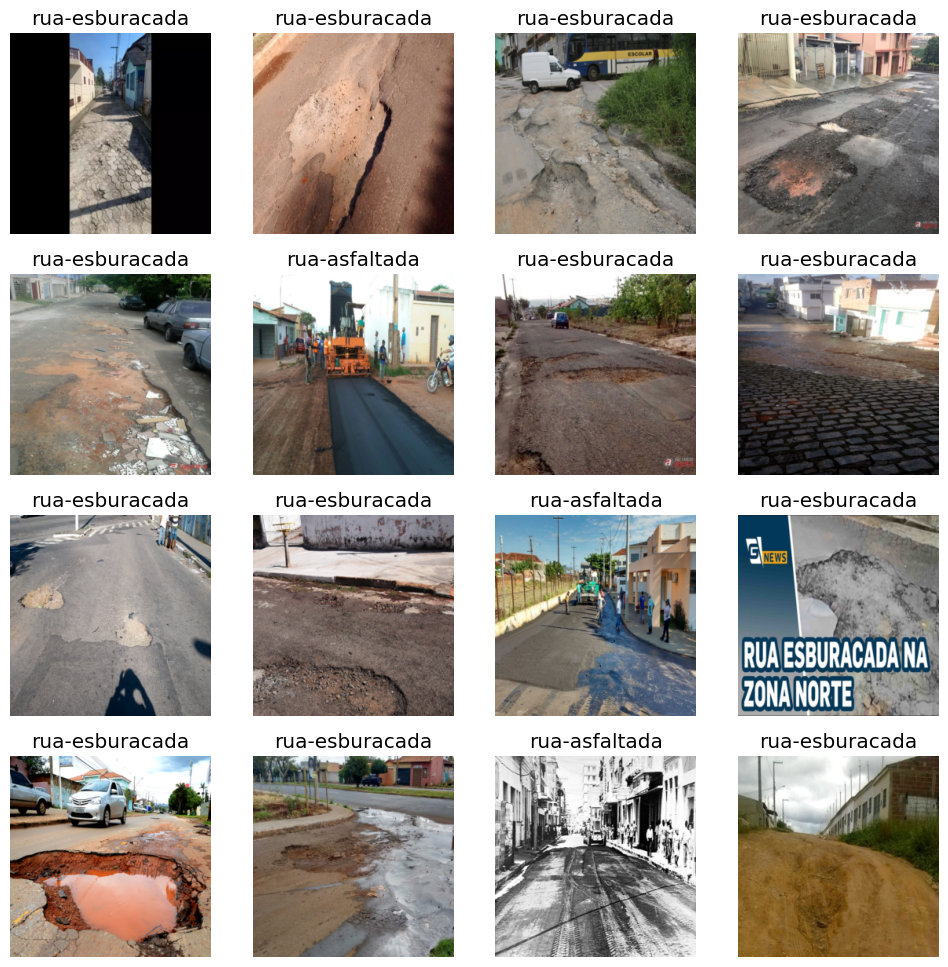

In [4]:
novoDataBlock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=70)

novoDataBlock.show_batch(max_n=16)

Abaixo treinaremos o modelo utilizando a função 'vision_learner', na qual a 'restnet18' é a rede neural convolucional utilizada. Logo após utilizamos o 'fine_tune', que utiliza modelos pré-treinados para melhorar o modelo já criado.

In [5]:
learn = vision_learner(novoDataBlock, resnet18, metrics=error_rate)
learn.fine_tune(6)

/home/antonio/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/antonio/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.469552,1.823796,0.527778,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.847008,0.866707,0.388889,00:43
1,0.663117,0.401838,0.222222,00:42
2,0.509019,0.216217,0.111111,00:44
3,0.387550,0.139755,0.055556,00:39
4,0.307227,0.106836,0.055556,00:55
5,0.256383,0.089279,0.000000,00:54


Agora podemos testar o modelo treinado.

Predição: rua-asfaltada.
Probabilidades: Rua asfaltada: 0.9990 and Rua esburacada: 0.0010


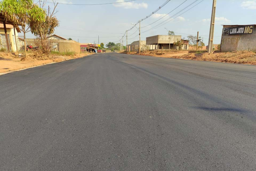

In [7]:
from fastdownload import download_url

imageURL = 'https://rondoniadinamica.com/uploads/aa4ccga7crdv5yv.jpeg'
nomeIMG = 'aa4ccga7crdv5yv.jpeg'
download_url(imageURL, '', show_progress=False)
resultado,_,probs = learn.predict(PILImage.create(nomeIMG))

print(f"Predição: {resultado}.")
print(f"Probabilidades: Rua asfaltada: {probs[0]:.4f} and Rua esburacada: {probs[1]:.4f}")

Image.open(nomeIMG).to_thumb(256,256)